##### In this file I will using the Breast Cancer Wisconsin dataset to train a
##### model to predict if a patient has cancer or not ( benign vs malignant)
##### Im going to define a CNN based algorithm to receive the vector of features which is available in this dataset as input to predict the results.
##### The dataset is available at: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29
##### https://www.kaggle.com/uciml/breast-cancer-wisconsin-data
##### 30 features are extracted from each image.
##### Class distribution: 357 benign, 212 malignant
## SOME NOTES:
## Since input is vector of features: Im Using L1 regularization of factor 0.01 applied to the kernel matrix, the reason is that L1 is acting like feature optimization, and sparsing the data.
## Max pooling is also so effective to provide robust results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPool1D, GlobalAveragePooling1D
from sklearn import preprocessing
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from keras.layers import LeakyReLU

## GOLOBAL VARIABLES ##

dataset_dir = '/kaggle/input/breast-cancer-wisconsin-data/data.csv'
SAVE_MODEL_DIR = '../kaggle/working/best_model.h5'

## DEFINE THE DATASET AND THE ARCHITECTURE

In [2]:
#################
# Importing the dataset


class dataset():
    def __init__(self):
        self.data = pd.read_csv(dataset_dir)
        # self.data.drop(['id'],axis=1,inplace=True)

    # define a function to do label encoding
    def label_encoding(self):
        le = preprocessing.LabelEncoder()
        self.data['diagnosis'] = le.fit_transform(self.data['diagnosis'])
        return self.data
    # Define a function to prepare X and Y out of the data

    def prepare_data(self):
        self.data = self.label_encoding()
        self.X = self.data.drop(columns=['diagnosis', 'id', 'Unnamed: 32'], axis=1)
        self.Y = self.data['diagnosis']
        return self.X, self.Y
    # Define a function to split the data into train and test, standard scalar them, and reshape them to fit the CNN

    def data_preparation(self):
        self.X, self.Y = self.prepare_data()
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.X, self.Y, test_size=0.2, random_state=42)
        self.scaler = StandardScaler()
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)
        self.X_train = self.X_train.reshape(self.X_train.shape[0], self.X_train.shape[1], 1)
        self.X_test = self.X_test.reshape(self.X_test.shape[0], self.X_test.shape[1], 1)
        return self.X_train, self.X_test, self.Y_train, self.Y_test
###############################
# Define the CNN model: we are going to define a CNN model with the following architecture:
# 1. Convolutional layer with 32 filters and a kernel size of 3
# 2. Using Leaky Relu activation function is better than Relu on the output of the convolutional layer
# 3. Using L1 regularization of factor 0.01 applied to the kernel matrix, since the input is features
# and L1 regularization is a way of feature selection
# 4. Batch Normalization
# 5 . Dropout


class CNN():
    def __init__(self, X_train, X_test, Y_train, Y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test
        self.model = Sequential()

    def model_architecture(self):
        self.model.add(Conv1D(32, 2, input_shape=(30, 1), kernel_regularizer=keras.regularizers.l1(0.01), kernel_initializer='HeNormal'))
        self.model.add(LeakyReLU(alpha=0.01))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.2))
        self.model.add(MaxPool1D(pool_size=2, padding='same'))
        self.model.add(Conv1D(64, 2, kernel_regularizer=keras.regularizers.l1(0.01), kernel_initializer='HeNormal'))
        self.model.add(LeakyReLU(alpha=0.01))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.2))
        self.model.add(MaxPool1D(pool_size=2, padding='same'))
        self.model.add(Conv1D(128, 2, kernel_regularizer=keras.regularizers.l1(0.01), kernel_initializer='HeNormal'))
        self.model.add(LeakyReLU(alpha=0.01))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.2))
        self.model.add(Conv1D(256, 2, kernel_regularizer=keras.regularizers.l1(0.01), kernel_initializer='HeNormal'))
        self.model.add(LeakyReLU(alpha=0.01))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.2))
        self.model.add(GlobalAveragePooling1D())
        self.model.add(Dense(128))
        self.model.add(LeakyReLU(alpha=0.01))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(32))
        self.model.add(Dense(1, activation='sigmoid'))
        return self.model


    def plot_history_accuracy(self, history):
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        axs[0].plot(history.history['accuracy'], label='accuracy')
        axs[0].plot(history.history['val_accuracy'], label='val_accuracy')
        axs[0].set_ylabel('Accuracy')
        axs[0].set_xlabel('Epoch')
        axs[0].set_title('Model Accuracy')
        axs[0].legend(loc='lower right')
        axs[1].plot(history.history['loss'], label='loss')
        axs[1].plot(history.history['val_loss'], label='val_loss')
        axs[1].set_ylabel('Loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_title('Model Loss')
        axs[1].legend(loc='upper right')
        plt.tight_layout()
        plt.show()

    # Define a function to train the model

    def train_evaluation_model(self, BATCH_SIZE=32, EPOCHS=50):
        self.model = self.model_architecture()
        self.model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
        # Define a callback function to save the model for the best validation accuracy
        callback = tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_MODEL_DIR, monitor='val_accuracy', save_best_only=True, verbose=1)
        # REDUCE LEARNING RATE ON PLATEU
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.8, patience=6, min_lr=0.00001, verbose=1)
        # fit the model:
        history = self.model.fit(self.X_train, self.Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(self.X_test, self.Y_test), verbose=1, callbacks=[callback, reduce_lr])
        # self.plot_history(history)
        self.plot_history_accuracy(history)
        predict_labels = (self.model.predict(self.X_test) > 0.5).astype(np.int32)
        print(classification_report(self.Y_test, predict_labels))
        ###
        print("Accuracy on the test Step:", accuracy_score(self.Y_test, predict_labels))
        # show confusion matrix
        conf_matrix = confusion_matrix(self.Y_test, predict_labels)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cbar=False, xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])

    # Define a function to evaluate the model

    # def evaluate_model(self):
    #     self.model1 = self.model_architecture()
    #     self.model1.load_weights(SAVE_MODEL_DIR)
    #     predict_labels = (self.model1.predict(self.X_test) > 0.5).astype(np.int)
    #     print(classification_report(self.Y_test, predict_labels))
    #     ###
    #     print("Accuracy on the test Step:", accuracy_score(self.Y_test, predict_labels))
    #     # show confusion matrix
    #     conf_matrix = confusion_matrix(self.Y_test, predict_labels)
    #     sns.heatmap(conf_matrix, annot=True, fmt="d", cbar=False, xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])

## TRAIN VALIDATE AND TEST THE MODEL:

(569, 30) (569,)
Epoch 1/150
38/38 [==============================] - 4s 26ms/step - loss: 69.8250 - accuracy: 0.7319 - val_loss: 68.1760 - val_accuracy: 0.6579

Epoch 00001: val_accuracy improved from -inf to 0.65789, saving model to ../kaggle/working/best_model.h5
Epoch 2/150
38/38 [==============================] - 0s 13ms/step - loss: 66.5350 - accuracy: 0.8220 - val_loss: 64.9347 - val_accuracy: 0.7544

Epoch 00002: val_accuracy improved from 0.65789 to 0.75439, saving model to ../kaggle/working/best_model.h5
Epoch 3/150
38/38 [==============================] - 0s 12ms/step - loss: 63.4131 - accuracy: 0.8418 - val_loss: 61.8039 - val_accuracy: 0.9035

Epoch 00003: val_accuracy improved from 0.75439 to 0.90351, saving model to ../kaggle/working/best_model.h5
Epoch 4/150
38/38 [==============================] - 0s 12ms/step - loss: 60.4475 - accuracy: 0.8132 - val_loss: 58.8217 - val_accuracy: 0.9123

Epoch 00004: val_accuracy improved from 0.90351 to 0.91228, saving model to ../kag

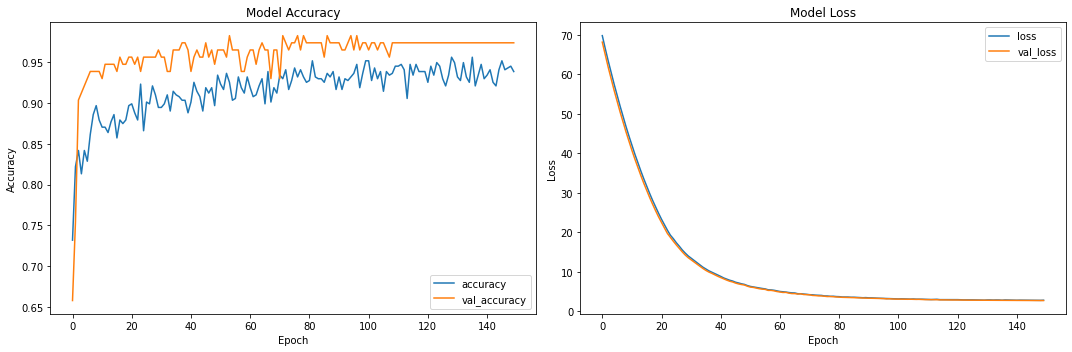

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Accuracy on the test Step: 0.9736842105263158


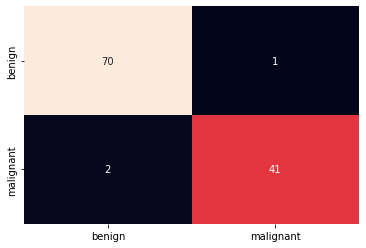

In [3]:
def main():
    # Initialize the dataset class
    dataset_obj = dataset()
    # Prepare the data
    X, Y = dataset_obj.prepare_data()
    print(X.shape, Y.shape)
    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = dataset_obj.data_preparation()
    # Initialize the CNN class
    cnn_obj = CNN(X_train, X_test, Y_train, Y_test)
    # Train the model
    cnn_obj.train_evaluation_model(BATCH_SIZE=12, EPOCHS=150)


if __name__ == '__main__':
    main()